In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# to cache results
import joblib
LOCATION = './cachedir'
MEMORY = joblib.Memory(LOCATION, verbose=0)

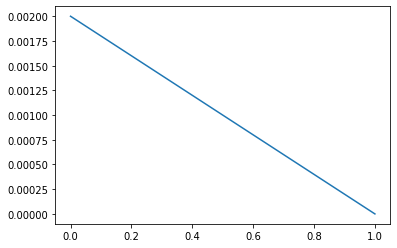

In [3]:
def new_theta(precision=1000):
    return np.linspace(0,1,precision)
def new_prior(precision=1000):
    prior = 1-new_theta(precision)
    return prior/sum(prior)
plt.plot(new_theta(),new_prior())

# Prior updates 

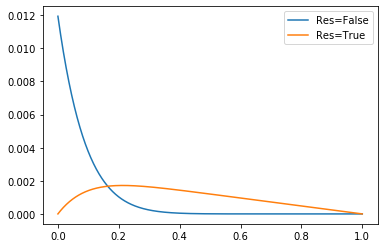

In [4]:
def update_prior(theta, prior, number_of_mixed_samples, test_result):
    """
    This function computes the posterior distribution if we observed
    a result "test_result" that is the maximum of "number_of_mixed_samples"
    bernoulli random variables
    """
    if test_result:
        posterior = (1-(1-theta)**number_of_mixed_samples)*prior
    else:
        posterior = (1-theta)**number_of_mixed_samples * prior
    return posterior / sum(posterior)

theta = new_theta(1000)
prior = new_prior(1000)
plt.plot(theta,update_prior(theta, prior, 10,0), label='Res=False')
plt.plot(theta,update_prior(theta, prior, 10,1), label='Res=True')
plt.legend()

In [5]:
def performance_policy(policy, p, number_samples, precision=1000):
    """
    This function takes as input:
    - "policy" is a function that returns the number of samples to be mixed as a function of the prior. 
    - "p" is the 'true' probability of being positive
    - 'number_of_samples' is the total number of samples
    - 'precision [=1000]' is the number of discretization steps of the prior
    """
    theta = new_theta(precision)
    prior = new_prior(precision)
    for i in range(number_samples):
        number_of_tests = policy(prior)
        result = np.random.rand() <= 1-(1-p)**number_of_tests
        prior = update_prior(theta, prior, number_of_tests, result)
    return prior

def confidence_interval95(policy, p, number_samples, precision=1000):
    """
    Computes the average confidence interval for the posterior avec 'number_samples'
    """
    posterior = np.cumsum(performance_policy(policy, p, number_samples, precision))
    lower = next(i for i,p in enumerate(posterior) if p>.025)
    upper = next(i for i,p in enumerate(posterior) if p>.975)
    return lower/len(posterior), upper/len(posterior)

In [6]:
# These are examples of policies: 

def baseline(prior):
    """We always make 1 test per sample (baseline)"""
    return 1
def double(prior):
    """We always mix 2 samples before doing a test"""
    return 2
def triple(prior):
    """We always mix 3 samples before doing a test"""
    return 3

def closest_to_one_half(prior):
    """ We choose the number of samples so that on average the probability of a positive test is close to 1/2. 
    """
    mean_proba = np.sum(np.arange(0,len(prior))*prior)/len(prior)
    return max(1,np.round(-np.log(2)/np.log(1-mean_proba)))


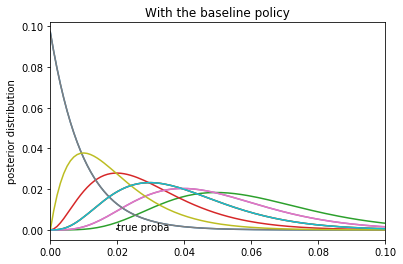

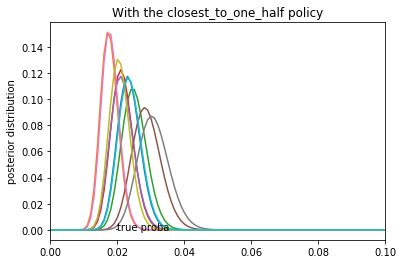

In [7]:
# Illustration: with 100 tests
for p in [0.02]: 
    for policy in [baseline, closest_to_one_half]:
        plt.figure()
        for i in range(10):
            plt.plot(theta, performance_policy(policy, p, 100))
        plt.plot([p, p], [0,0.001], 'k--', label='True proba')
        plt.text(p,-.0001,'true proba')
        plt.xlim([0,0.1])
        plt.ylabel('posterior distribution')
        plt.title('With the {} policy'.format(policy.__name__))

In [10]:
# Some average tests
@MEMORY.cache
def average_confidence_intervals(policy, p, number_samples, precision=1000, number_of_repetitions=100):
    upp_low = np.zeros((number_of_repetitions,2))
    for i in range(number_of_repetitions):
        upp_low[i,:] = confidence_interval95(policy, p, number_samples, precision)
    mean = np.mean(upp_low, 0)
    conf = 2*np.sqrt(np.var(upp_low,0)/number_of_repetitions) # sort of quick confidence interval
    return np.array([mean[0], mean[1], conf[0], conf[1]])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Here, we want how many persons are infected. We plot the curves for an infection proba of 0.5% to 10%. 

Conclusion: using grouped test is much more efficient, especially for small values of $p$. 
- The 'baseline' test with 50 samples cannot differentiate between 0.5% and 10%
- With the strategy 'closest_to_one_half', we can differentiate between 0.75% and 2%

baseline computed
double computed
triple computed
closest_to_one_half computed


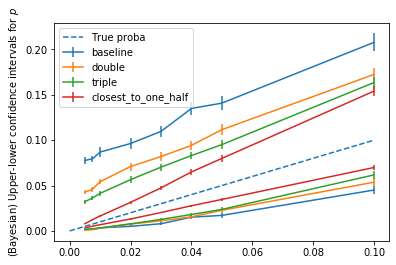

In [19]:
# This can be slow the first time (up to 1 to several minutes). Much faster after. 
number_of_samples = 50

myP = [0.005,0.0075, 0.01,0.02,0.03,0.04,0.05,0.1]
for i,policy in enumerate([baseline, double, triple, closest_to_one_half]):
    perf = np.zeros((len(myP),4))
    for j,p in enumerate(myP):
        perf[j,:] = average_confidence_intervals(policy, p, number_of_samples)
    print(policy.__name__,'computed')
    plt.errorbar(myP, perf[:,0], perf[:,2], color=colors[i], label=policy.__name__)
    plt.errorbar(myP, perf[:,1], perf[:,3], color=colors[i])
    plt.ylabel('(Bayesian) Upper-lower confidence intervals for $p$')
plt.plot([0,max(myP)],[0,max(myP)], '--', label='True proba')
plt.legend()


In [31]:
for i,p in enumerate(myP):
    print('True p=',100*p, '%\tEsimated \in[',100*perf[i,0:2],']')

True p= 0.5 %	Esimated \in[ [0.329 0.795] ]
True p= 0.75 %	Esimated \in[ [0.518 1.241] ]
True p= 1.0 %	Esimated \in[ [0.684 1.642] ]
True p= 2.0 %	Esimated \in[ [1.315 3.146] ]
True p= 3.0 %	Esimated \in[ [2.024 4.743] ]
True p= 4.0 %	Esimated \in[ [2.772 6.494] ]
True p= 5.0 %	Esimated \in[ [3.467 7.986] ]
True p= 10.0 %	Esimated \in[ [ 6.987 15.405] ]


# Next? 
- Same with false positives / negatives